In [ ]:
# -*- coding: utf-8 -*-
"""
@author: Timur Galimzyanov
"""
!rm -r /content/Neural-net-optimization-with-consecutive-pruning
!git clone https://github.com/galtimur/Neural-net-optimization-with-consecutive-pruning

rm: cannot remove '/content/Neural-net-optimization-with-consecutive-pruning': No such file or directory
Cloning into 'Neural-net-optimization-with-consecutive-pruning'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 50 (delta 26), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), 17.09 KiB | 1.42 MiB/s, done.


Importing libraries and defining seed everything function

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import random
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torch.optim.lr_scheduler as sched
from torch.utils.data.dataloader import default_collate

import gc

import sys
sys.path.insert(1, '/content/Neural-net-optimization-with-consecutive-pruning')

# Loading pruning functions
from prun_functions import prune_model, reprune_model_local, unprune_model, count_non_zero
# Loading MLP models and train data generation functions
from mlp_setup import Teacher, Student, gen_train

# Importing functions for plotting results and e.t.c.
from plotting_results import plot_train, loss_landscape1D, loss_landscape2D, plot_landscape1D, plot_landscape2D

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed):

    '''
    Seed
    '''

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Testing pruning functions

In [ ]:
model = Student(n_in = 30, n_out = 5, hidden = 20)
model.to(device)
pruns = np.arange(0.9, -0.01, -0.1)
pruns = np.arange(0.1, 0.9, 0.1)

for i, alpha in enumerate(pruns):

    if i == 0:    
        prune_model(model, alpha=alpha)
    else:
        reprune_model_local(model, alpha=alpha)

    print(f'Amount of nonzero params = {count_non_zero(model):.3f}')

Amount of nonzero params = 0.900
Amount of nonzero params = 0.800
Amount of nonzero params = 0.700
Amount of nonzero params = 0.600
Amount of nonzero params = 0.500
Amount of nonzero params = 0.400
Amount of nonzero params = 0.300
Amount of nonzero params = 0.200


Traning function. Trains model n_epochs.

Returns timeseries of losses - train, validation and OOD

In [ ]:
def train(model, train_loader, optimizer, device, n_epochs = 5, loss_fun = nn.L1Loss(), scheduler = None):

    '''
    Traning function
    Returns timeseries of losses - train, validation and OOD
    '''

    losses = []
    losses_val = []
    losses_ODD = []
    
    #loss_fun = nn.CosineEmbeddingLoss()
    model.train()

    for epoch in range(n_epochs):#tqdm(range(n_epochs)):
    
        for features, targets in train_loader:
        
            res = model(features.to(device))
            loss = loss_fun(res, targets.to(device)) #, torch.ones(len(targets)).to(device)
            
            with torch.no_grad():   
                res_val = model(X_test.to(device))
                loss_val = loss_fun(res_val, y_test.to(device)).item()
                losses_val.append(loss_val/val_norm)
                
                res_ODD = model(train_ODD.to(device))
                loss_ODD = loss_fun(res_ODD, target_ODD.to(device)).item()
                losses_ODD.append(loss_ODD/ODD_norm)
                
            model.zero_grad()
            loss.backward()
            losses.append(loss.item()/train_norm)
            optimizer.step()
        
        if scheduler != None:
            scheduler.step()
    
    return losses, losses_val, losses_ODD

In [ ]:
train_samples, target_orig, train_ODD, target_ODD = gen_train(hidden_size = 200, new = True)
n_in = train_samples.size()[1]
n_out = target_orig.size()[1]

## Addition of the random noise to the target
alpha = 0.1
std = torch.std(target_orig)
target = target_orig + alpha*std*torch.randn_like(target_orig)

var = torch.var(target_ODD)
target_ODD = target_ODD + alpha*var*torch.randn_like(target_ODD)

## L1 norm of the original data to normalize L1 loss.
train_orig_norm = (abs(target_orig)).mean().item()

loss_fun = nn.L1Loss()
print('base loss = ', loss_fun(target, target_orig).item()/train_orig_norm)

seed_everything(42)

X_train, X_test, y_train, y_test = train_test_split(train_samples, target, test_size = 0.1, train_size = 0.9)
train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

#train_norm = (abs(y_train)).mean().item()
#val_norm = (abs(y_test)).mean().item()
val_norm = train_orig_norm
train_norm = train_orig_norm

ODD_norm = (abs(target_ODD)).mean().item()

base loss =  0.09941038295408124


Functions for model training

In [ ]:
def train_model(train_loader, device, seed=42, hidden_size = 100, plot_text=''):

    seed_everything(seed)
    
    model = Student(n_in = n_in, n_out = n_out, hidden = hidden_size)
    #model = torch.load('teacher.pt')
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-2, weight_decay=0.01)
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    
    scheduler = sched.MultiStepLR(optimizer, milestones=[2,3,4,5,6,7,8,9,10], gamma=0.7)
    #scheduler = None
    
    res = train(model, train_loader, optimizer, device, n_epochs = 2, scheduler = scheduler)
    print(f'Amount of nonzero params = {count_non_zero(model):.3f}')
    plot_train(res, 2, plot_text)
    
    # model_copy = copy.deepcopy(model)
    return model

Functions for model training at consequative prunning levels 

In [ ]:
def train_pruning(pruns, train_loader, device, seed=42, hidden_size = 100, n_epochs=5,
                  plot_text='', to_plot = True):
    
    global result
    
    seed_everything(seed)
    
    model = Student(n_in = 30, n_out = 5, hidden = hidden_size)
    #model = torch.load('teacher.pt')
    model.to(device)

    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
       
    optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-3, weight_decay=0.00) 
    
    # unprune_model(model)
    res_train = []
    res_val = []
    res_OOD = []
    gamma = 1

    for i, alpha in enumerate(pruns):
        #seed_everything(42)
        if i == 0:    
            prune_model(model, alpha=alpha)
        else:
            reprune_model_local(model, alpha=alpha)
        #if i == len(pruns) - 1 and len(pruns)>1:
        #    gamma = 3
                  
        scheduler = None
        #scheduler = sched.MultiStepLR(optimizer, milestones=[10, 20, 30], gamma=0.33)
        
        res = train(model, train_loader, optimizer, device, n_epochs = gamma*n_epochs, scheduler = scheduler)
        res_train += res[0]
        res_val += res[1]
        res_OOD += res[2]
        
    result = (res_train, res_val, res_OOD)
    #plot_text = f'prun ratio = {alpha:.2f}'
    if to_plot:    
        plot_text = ''
        plot_train(result, 1, plot_text)
        
    print(f'Amount of nonzero params = {count_non_zero(model):.3f}')
    
    unprune_model(model)
        
    return result

#Main part
where I train the model with concequativly decreasing of prunning ratio

Performing depruning training for a different seeds to evaluate the approach at OOD data

In [ ]:

pruns = list(np.arange(0.9, -0.01, -0.1))
pruns = [0.95] + pruns
seeds = list(range(1,81))
#seeds = [1,2]
prun_losses = []

for seed in seeds:
    res_tmp = train_pruning(pruns, train_loader, device, seed=seed, hidden_size = 100,
                            n_epochs=10, to_plot=False)[2][-100:];
    #print(len(res_tmp))
    prun_losses += res_tmp

Amount of nonzero params = 0.583
Amount of nonzero params = 0.600
Amount of nonzero params = 0.708
Amount of nonzero params = 0.697
Amount of nonzero params = 0.658
Amount of nonzero params = 0.649
Amount of nonzero params = 0.618
Amount of nonzero params = 0.604
Amount of nonzero params = 0.613
Amount of nonzero params = 0.587
Amount of nonzero params = 0.609
Amount of nonzero params = 0.642
Amount of nonzero params = 0.657
Amount of nonzero params = 0.593
Amount of nonzero params = 0.626
Amount of nonzero params = 0.598
Amount of nonzero params = 0.675
Amount of nonzero params = 0.660
Amount of nonzero params = 0.604
Amount of nonzero params = 0.612
Amount of nonzero params = 0.624
Amount of nonzero params = 0.588
Amount of nonzero params = 0.629
Amount of nonzero params = 0.630
Amount of nonzero params = 0.638
Amount of nonzero params = 0.664
Amount of nonzero params = 0.630
Amount of nonzero params = 0.633
Amount of nonzero params = 0.625
Amount of nonzero params = 0.636
Amount of 

Performing training of full and small models to analyze their OOD performance 

In [ ]:
pruns = [0]

full_losses = []

print('Training full size model (hidden = 200)')
for seed in seeds:
    res_tmp = train_pruning(pruns, train_loader, device, seed=seed, hidden_size = 200,
                            n_epochs=110, to_plot=False)[2][-100:];
    full_losses += res_tmp

print('Training small model (hidden = 100)')
cut_losses = []
for seed in seeds:
    res_tmp = train_pruning(pruns, train_loader, device, seed=seed, hidden_size = 100,
                            n_epochs=110, to_plot=False)[2][-100:];
    cut_losses += res_tmp

Training full size model (hidden = 200)
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amount of nonzero params = 1.000
Amo

Plotting the histogrmas of the OOD losses. Cut model pruned and not pruned demonstrates similar results.

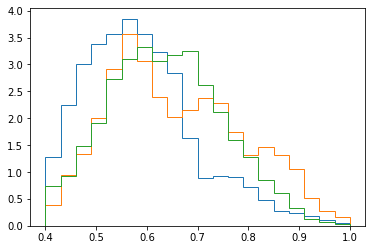

In [ ]:
#plt.hist((full_losses, cut_losses, prun_losses), density=False, bins=100,
#          range = (0.0,2), stacked=True, label = ("full", "cut", "prun"))  # density=False would make counts

plt.figure()
plt.hist(full_losses, bins=20, range = (0.4,1), stacked=True, histtype='step', fill=False, density = True) #, fill=False, color="red"
plt.hist(cut_losses, bins=20, range = (0.4,1), stacked=True, histtype='step', fill=False, density = True)
plt.hist(prun_losses, bins=20, range = (0.4,1), stacked=True, histtype='step', fill=False, density = True)
plt.show()

#plt.legend(loc='upper right')
#plt.ylabel('Probability')
#plt.xlabel('Loss');

In [ ]:
print(np.mean(full_losses), np.std(full_losses))
print(np.mean(cut_losses), np.std(cut_losses))
print(np.mean(prun_losses), np.std(prun_losses)) 

0.6139564076093511 0.11524692048700573
0.6632007500722843 0.14588076819374357
0.6400502716210699 0.14526876654842305


In [ ]:
#train_model(train_loader, seed=42, hidden_size=200)

#%%

###
###
# Different debugs
###
###

# model = Student(n_in = 30, n_out = 5, hidden = 200)
# model.to(device)

# print(model.lin3.bias)

# optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-2, weight_decay=0.01)
# #train(model, optimizer, n_epochs = 1, scheduler = None)
# prune_model(model, alpha=0.8)

# print(model.lin3.bias)
# print(model.lin3.bias_mask)

# train(model, optimizer, n_epochs = 1, scheduler = None)

# print(model.lin3.bias)
# print(model.lin3.bias_mask)

# reprune_model_local(model, alpha=0.2)

# print(model.lin3.bias)
# print(model.lin3.bias_mask)


#%%
# model = Student(n_in = 30, n_out = 5, hidden = 200)
# old_model = Student(n_in = 30, n_out = 5, hidden = 200)

# model.to(device)

# # torch.save(model, 'old_model.pt')

# #print(model.lin3.bias)
# prune_model(model, alpha=0.2)
# print(model.lin3.bias_mask)
# print(model.lin3.bias)
# print(model.lin3.bias_orig)

# optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-2, weight_decay=0.01)
# train(model, optimizer, n_epochs = 20, scheduler = None)



# print(model.lin3.bias)
# print(model.lin3.bias_orig)

# print('-----Pruning-----')
# reprune_model_local(model, alpha=0.2)
# print(model.lin3.bias_mask)
# print(model.lin3.bias)
# print(model.lin3.bias_orig)

# print(f'Amount of nonzero params = {count_non_zero(model):.3f}')

# #print(list((dict(model.named_buffers()).keys())))

#%%

# model = Student(n_in = n_in, n_out = n_out, hidden = 200)
# print(model)
# model = torch.load('teacher.pt')
# print(model)
# model.to(device)

# loss_fun = nn.L1Loss()
# res_ODD = model(train_ODD.to(device))
# loss_ODD = loss_fun(res_ODD, target_ODD.to(device)).item()

# print(loss_ODD)

# print(f' number of nonzero params = {count_non_zero(model.lin3.weight):.3f}')


#%%

'''
Just looking on the loss landscape of the interpolation of three and two models
'''

model1 = train_model(train_loader, device, seed=42, hidden_size=200)
model2 = train_model(train_loader, device, seed=420, hidden_size=200)
model0 = Student(n_in = n_in, n_out = n_out, hidden = 100)
model0 = torch.load('teacher.pt')
model0.to(device)

model0 = train_model(train_loader, device, seed=1420, hidden_size=200)

model_temp = Student(n_in = n_in, n_out = n_out, hidden = 200)

res = loss_landscape2D(model0, model1, model2, model_temp, X_train, y_train, train_ODD, target_ODD, train_ODD, target_ODD)
plot_landscape2D(res, n_cont=100, ODD=False)

#%%

losses = loss_landscape1D(model0, model2, X_train, y_train, train_ODD, target_ODD, train_ODD, target_ODD)
plot_landscape1D(losses)

#%%

model1 = train_pruning(device, seed=1)
model2 = train_pruning(device, seed=2)

#%%

losses = loss_landscape1D(model1, model2, X_train, y_train, train_ODD, target_ODD, train_ODD, target_ODD)
plot_landscape1D(losses)

#%%

'''
Here I tried to construct a classifier
'''

num_sample = 31

targets = [-5., -3., -1., 1., 3., 5.]

target_samples = []
train_samples = []

for target in targets:
    targer_sample = torch.normal(mean = target, std =  0.5, size=(num_sample, 30))
    train_samples.append(targer_sample)
    target_samples += num_sample*[target]

train_samples = torch.cat(train_samples)
target_samples = torch.tensor(target_samples)

#print(train_probs)

# train_probs = torch.softmax(train_res, dim=1)
# qq = torch.argmax(train_probs, dim=1)
# print(qq)
# print(qq.float().mean().item())